# Let's get started! ⚡

In [1]:
## import Module

# Exploratory Data Analysis
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# warnings
import warnings
warnings.filterwarnings('ignore')

# Data Preprocessing
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split

# Hyperparameter tuning
from hyperopt import hp
from hyperopt import fmin, tpe, Trials
from sklearn.model_selection import cross_val_score
from hyperopt import STATUS_OK

# LightGBM Training
import lightgbm
from lightgbm import LGBMClassifier

# Data Reading

In [2]:
# 데이터 읽어오기
df_train = pd.read_csv('./train.csv')
df_test = pd.read_csv('./test.csv')

In [3]:
# 헤드 확인
df_train.head()

PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S  
3      0            113803  53.1000  C123        S  
4      0            373450   8.0500   NaN        S

In [4]:
# 데이터의 컬럼 수 확인
print(df_train.shape, df_test.shape)

(891, 12) (418, 11)


In [5]:
# 컬럼별 타입과 Null값 확인
print(df_train.info())
print()
print(df_test.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pc

# Data Preprocessing ⚙️🧹

## 1차 전처리 함수 선언

In [6]:
# 학습데이터와 테스트데이터 합치기
def concat_train_test_data(df_train=None, df_test=None):
    df1 = df_train.drop(columns='Survived')
    df = pd.concat([df1, df_test], axis=0, sort=False)
    df['PassengerId'] = df['PassengerId'].astype(int)
    return df

In [7]:
# 'Name' 컬럼에서 'honorific_title' 컬럼 생성하기
# 의미있는 호칭(Mr, Mrs, Miss, Master)을 추출하는 과정입니다.

# 'honorific_title' 생성하는 함수
def get_honorific_title(name=None):
    top4_titles = ('Mr', 'Mrs', 'Miss', 'Master')

    # top4 호칭으로 바꿔줄 소수 여성 호칭
    female_titles_to_Mrs = ('Mme', 'the Countess', 'Dona', 'Lady')
    female_titles_to_Miss = ('Mlle', 'Ms')

    # top4 호칭으로 바꿔줄 소수 남성 호칭
    male_titles_to_Mr = ('Major', 'Col', 'Capt', 'Don', 'Sir', 'Jonkheer', 'Rev')

    # 예 : "Braund, Mr. Owen Harris"에서 'Mr' 추출
    # '.'(마침표) 기준으로 이름을 자르고, ','(콤마) 제거
    honorific_title = name.split('.')[0].split(', ')[-1]

    # 호칭에 따라 변환해서 리턴
    if honorific_title in top4_titles:
        return honorific_title
    elif honorific_title in female_titles_to_Mrs:
        return 'Mrs'
    elif honorific_title in female_titles_to_Miss:
        return 'Miss'
    elif honorific_title in male_titles_to_Mr:
        return 'Mr'
    else:
        return honorific_title

In [8]:
# 남녀 양쪽 전부 존재하는 호칭 처리 함수
def processing_honorific_title_on_both_side(df=None):
    # 조건 설정
    title_on_both_side = ['Dr']
    cond_mr = (df['Sex'] == 'male') & (df['honorific_title'].isin(title_on_both_side))
    cond_mrs = (df['Sex'] == 'female') & (df['honorific_title'].isin(title_on_both_side))
    
    # 치환
    df.loc[cond_mr, 'honorific_title'] = 'Mr'
    df.loc[cond_mrs, 'honorific_title'] = 'Mrs'
    
    return df

In [9]:
# 새 피쳐로 사용할 컬럼 'honorific_title' 생성
def make_honorific_title(df=None):
    df['honorific_title'] = df['Name'].map(get_honorific_title)
    
    # 남녀 양쪽 전부 존재하는 호칭에 대한 처리
    df = processing_honorific_title_on_both_side(df)
    
    return df

In [10]:
# 'Surname'(성씨) 생성 후 가족별로 묶기
def make_Surname_FamilyGroup(df=None):
    df['Surname'] = df['Name'].map(lambda name: name.split(',')[0].strip())
    surname_counts = df['Surname'].value_counts()
    df['FamilyGroup'] = df['Surname'].map(surname_counts)
    return df

In [11]:
# 'Family', 'IsAlone' 생성
def make_Family_IsAlone(df=None):
    df['Family'] = df['SibSp'].astype(int) + df['Parch'].astype(int)
    df['IsAlone'] = (df['Family'] <= 1).astype(int)
    return df

In [12]:
# 'Cabin' 컬럼 매핑
def mapping_Cabin(df=None):
    df['Cabin'].fillna('Unknown', inplace=True)
    cabin_mapping = {cabin[0]: idx for idx, cabin in enumerate(sorted(set(cabin[0] for cabin in df['Cabin'].unique())))}
    df['Cabin'] = df['Cabin'].map(lambda x: cabin_mapping[x[0]])
    return df

In [13]:
# 'TicketGroup' 컬럼 생성
def make_TicketGroup(df=None):
    df["TicketGroup"] = df["Ticket"].map(
        df["Ticket"].value_counts()
    )
    return df

In [14]:
# 'Ticket' 종류별로 묶기
def categorize_Ticket(df=None):
    def process_ticket(data):
        # 단순 숫자만 있는 티켓들 분류
        number_ticket = data[data["Ticket"].str.isdigit()].copy()
        number_ticket['Ticket'] = number_ticket['Ticket'].astype(int)
        number_ticket.loc[number_ticket['Ticket'] <= 100000, 'Ticket'] = 14
        number_ticket.loc[(number_ticket['Ticket'] > 100000) & (number_ticket['Ticket'] <= 200000), 'Ticket'] = 15
        number_ticket.loc[(number_ticket['Ticket'] > 200000) & (number_ticket['Ticket'] <= 300000), 'Ticket'] = 13
        number_ticket.loc[(number_ticket['Ticket'] > 300000) & (number_ticket['Ticket'] <= 400000), 'Ticket'] = 5
        number_ticket.loc[number_ticket['Ticket'] > 3000000, 'Ticket'] = 6
        
        # 알파벳 포함된 티켓들을 종류별로 분류
        num_alpha_ticket = data[data["Ticket"].str.contains('[^\d]', na=False)].copy()
        num_alpha_ticket.loc[num_alpha_ticket['Ticket'].str.match('A.+', na=False), 'Ticket'] = 1
        num_alpha_ticket.loc[num_alpha_ticket['Ticket'].str.match('C\.*A\.*.+', na=False), 'Ticket'] = 8
        num_alpha_ticket.loc[num_alpha_ticket['Ticket'].str.match('PC.+', na=False), 'Ticket'] = 16
        num_alpha_ticket.loc[num_alpha_ticket['Ticket'].str.match('PP.+', na=False), 'Ticket'] = 18
        num_alpha_ticket.loc[num_alpha_ticket['Ticket'].str.match('SOTON.+', na=False), 'Ticket'] = 3
        num_alpha_ticket.loc[num_alpha_ticket['Ticket'].str.match('STON.+', na=False), 'Ticket'] = 11
        num_alpha_ticket.loc[num_alpha_ticket['Ticket'].str.match('LINE.*', na=False), 'Ticket'] = 7
        num_alpha_ticket.loc[num_alpha_ticket['Ticket'].str.match('F\.C\.(C\.)*.+', na=False), 'Ticket'] = 17
        num_alpha_ticket.loc[num_alpha_ticket['Ticket'].str.match('W.+', na=False), 'Ticket'] = 4
        num_alpha_ticket.loc[num_alpha_ticket['Ticket'].str.match('C.+', na=False), 'Ticket'] = 9
        num_alpha_ticket.loc[num_alpha_ticket['Ticket'].str.match('S(\.)*C.+', na=False), 'Ticket'] = 12
        num_alpha_ticket.loc[num_alpha_ticket['Ticket'].str.match('S(\.)*O.+', na=False), 'Ticket'] = 2
        num_alpha_ticket.loc[num_alpha_ticket['Ticket'].str.match('[^\d](Fa)*(P/PP)*(S\.P)*(S\.*W)*.+', na=False), 'Ticket'] = 10
        num_alpha_ticket['Ticket'] = num_alpha_ticket['Ticket'].apply(lambda x: int(x) if pd.notna(x) else x)

        processed_data = pd.concat([number_ticket, num_alpha_ticket])

        return processed_data

    # 처리
    data_processed = process_ticket(df)
    
    # 다시 합치기
    df = df.merge(data_processed[['PassengerId', 'Ticket']], on='PassengerId', how='left')
    df = df.drop('Ticket_x', axis=1)
    
    return df

In [15]:
# 필요없는 컬럽들 드랍 함수
def drop_columns(df=None):
    # 'PassengerId' 컬럼
    df = df.drop(columns=['PassengerId'])
    
    # 'Name' 컬럼
    df = df.drop(columns=['Name'])
    
    # 'Surname' 컬럼
    df = df.drop(columns=['Surname'])
    
    # 'SibSp', 'Parch' 컬럼
    # df = df.drop(columns=['SibSp','Parch'])
    
    # 'Family' 컬럼
    df = df.drop(columns=['Family'])
        
    return df

## 1차 전처리 함수 모음

In [16]:
# 1차 전처리 함수 모음
def first_preprocessing(df_train=None, df_test=None):
    # 학습데이터와 전처리데이터 합치기
    df = concat_train_test_data(df_train, df_test)
    
    # 호칭 만들기
    df = make_honorific_title(df)
    
    # 'Surname'(성씨) 생성 후 가족별로 묶기
    df = make_Surname_FamilyGroup(df)
    
    # 'Family', 'IsAlone' 생성
    df = make_Family_IsAlone(df)
    
    # 'Cabin' 컬럼 매핑
    df = mapping_Cabin(df)
    
    # 'TicketGroup' 컬럼 생성
    df = make_TicketGroup(df)
    
    # 'Ticket' 종류별로 묶기
    df = categorize_Ticket(df)
    
    # 필요없는 컬럼 삭제
    df = drop_columns(df)
       
    return df

In [17]:
# 1차 전처리 함수 실행
df = first_preprocessing(df_train, df_test)

## 1차 전처리 후 통계 확인

<Axes: xlabel='honorific_title'>

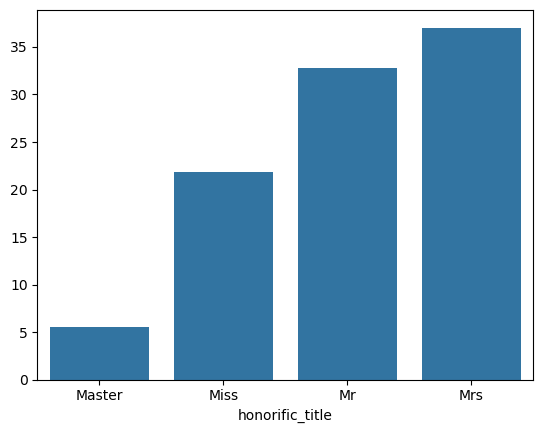

In [18]:
# 'honorific_title'에 따른 'Age' 분포 표시
sns.barplot(x=df.groupby('honorific_title')['Age'].agg(np.mean).index, y=df.groupby('honorific_title')['Age'].agg(np.mean).values)

<Axes: xlabel='Age', ylabel='honorific_title'>

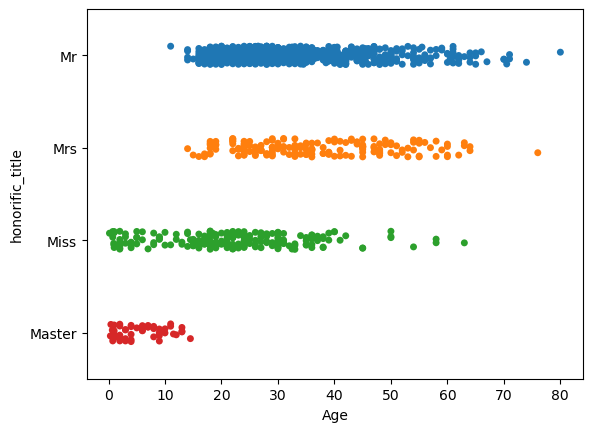

In [19]:
# Plot the distribution of Ages for each group
sns.stripplot(
      data=df
    , x='Age'
    , y='honorific_title'
    , hue='honorific_title'
)

In [20]:
df.groupby('honorific_title')['Age'].agg({'mean', 'median', 'max'})

mean   max  median
honorific_title                         
Master            5.482642  14.5     4.0
Miss             21.824366  63.0    22.0
Mr               32.784298  80.0    30.0
Mrs              37.040000  76.0    36.0

In [21]:
df.groupby('Pclass')['Fare'].agg({'mean', 'median', 'max'})

mean       max   median
Pclass                              
1       87.508992  512.3292  60.0000
2       21.179196   73.5000  15.0458
3       13.302889   69.5500   8.0500

In [22]:
df.head()

Pclass     Sex   Age  SibSp  Parch     Fare  Cabin Embarked  \
0       3    male  22.0      1      0   7.2500      8        S   
1       1  female  38.0      1      0  71.2833      2        C   
2       3  female  26.0      0      0   7.9250      8        S   
3       1  female  35.0      1      0  53.1000      2        S   
4       3    male  35.0      0      0   8.0500      8        S   

  honorific_title  FamilyGroup  IsAlone  TicketGroup  Ticket_y  
0              Mr            2        1            1         1  
1             Mrs            2        1            2        16  
2            Miss            1        1            1        11  
3             Mrs            2        1            2        15  
4              Mr            2        1            1         5

## 2차 전처리 함수 선언

### Imputer 함수 선언

In [23]:
# 'Age' 컬럼 결측치 채우기
def Age_Imputer(df=None):
    def fn(honorific_title=None, age=None):
        if np.isnan(age):
            if honorific_title == 'Master':
                return 5.48
            elif honorific_title == 'Miss':
                return 21.82
            elif honorific_title == 'Mr':
                return 32.78
            elif honorific_title == 'Mrs':
                return 37.04
        else:
            return age
    
    df['Age'] = df[['honorific_title', 'Age']].apply(lambda x: fn(x['honorific_title'], x['Age']),axis=1)
    df['Age'] = df['Age'].astype('int64')
    
    return df

In [24]:
# 'Fare' 컬럼 결측치 채우기
def Fare_Imputer(df=None):
    def fn(pclass=None, fare=None):
        if np.isnan(fare):
            if pclass == 1:
                return 60.0
            elif pclass == 2:
                return 15.04
            elif pclass == 3:
                return 8.05
        else:
            return fare
    
    df['Fare'] = df[['Pclass', 'Fare']].apply(lambda x: fn(x['Pclass'], x['Fare']),axis=1)
    
    return df

In [25]:
# 'Embarked' 컬럼 결측치 채우기
def Embarked_Imputer(df):
    # Null인 두 사람이 전부 Pclass=1 => '1'에는 'S'가 제일 많다.
    df.loc[df['Embarked'].isnull(), 'Embarked'] = 'S'
    return df

In [26]:
# 결측치 채우는 함수
def Data_Imputer(df=None):
    df = Age_Imputer(df)
    df = Fare_Imputer(df)
    df = Embarked_Imputer(df)
    return df

### 결측치 채운 후 전처리 함수 선언

In [27]:
# 'AgeCatogary' 생성
def make_AgeCategory(df=None):
    df['AgeCategory'] = pd.cut(df['Age'], bins=[-1, 18, 36, np.inf], labels=[1, 2, 3]).astype(int)
    return df

In [28]:
# 'IsChild', 'WomenChildren' 생성
def make_isChild_WomenChildren(df=None):
    df['IsChild'] = (df['Age'] < 18).astype(int)
    df['WomenChildren'] = ((df['Sex'] == 'female') | (df['IsChild'] == 1)).astype(int)
    return df

In [29]:
# 레이블 인코딩
def label_encoder(df=None):
    encoder = LabelEncoder()
    # 'Sex', 'Embarked', 'honorific_title' 컬럼을 레이블 인코딩
    columns =  ['Sex', 'Embarked', 'honorific_title']
    for column in columns:
        df[column] = encoder.fit_transform(df[column])
    
    return df

In [30]:
#  원핫 인코딩
def one_hot_encoder(df=None):
    return df

In [31]:
# 'Age', 'Fare' 스케일링
def Age_Fare_scalar(df=None):
    scalar = MinMaxScaler()
    df[['Age', 'Fare']] = scalar.fit_transform(df[['Age', 'Fare']])
    return df

In [32]:
# 컬럼명을 강제로 str로 형변환
def columns_index_to_str_type(df=None):
    df.columns = df.columns.astype(str)
    return df

## 2차 전처리 함수 모음

In [33]:
# 2차 전처리 함수 모음
def second_preprocessing(df=None):
    # 결측치 채우기
    df = Data_Imputer(df)
    
    # 'AgeCatogary' 생성
    df = make_AgeCategory(df)
    
    # 'IsChild', 'WomenChildren' 생성
    df = make_isChild_WomenChildren(df)
    
    # 레이블 인코딩
    df = label_encoder(df)
    
    # 원핫 인코딩
    # df = one_hot_encoder(df)
       
    # 'Age', 'Fare' 스케일링
    df = Age_Fare_scalar(df)
    
    # 컬럼명을 강제로 str로 형변환
    df = columns_index_to_str_type(df)
    
    return df

In [34]:
# 2차 전처리 함수 실행
df = second_preprocessing(df)

## 전처리 결과 확인

### 결측치 존재여부 확인

In [35]:
df.isnull().sum()

Pclass             0
Sex                0
Age                0
SibSp              0
Parch              0
Fare               0
Cabin              0
Embarked           0
honorific_title    0
FamilyGroup        0
IsAlone            0
TicketGroup        0
Ticket_y           0
AgeCategory        0
IsChild            0
WomenChildren      0
dtype: int64

### 피어슨 계수 행렬 시각화

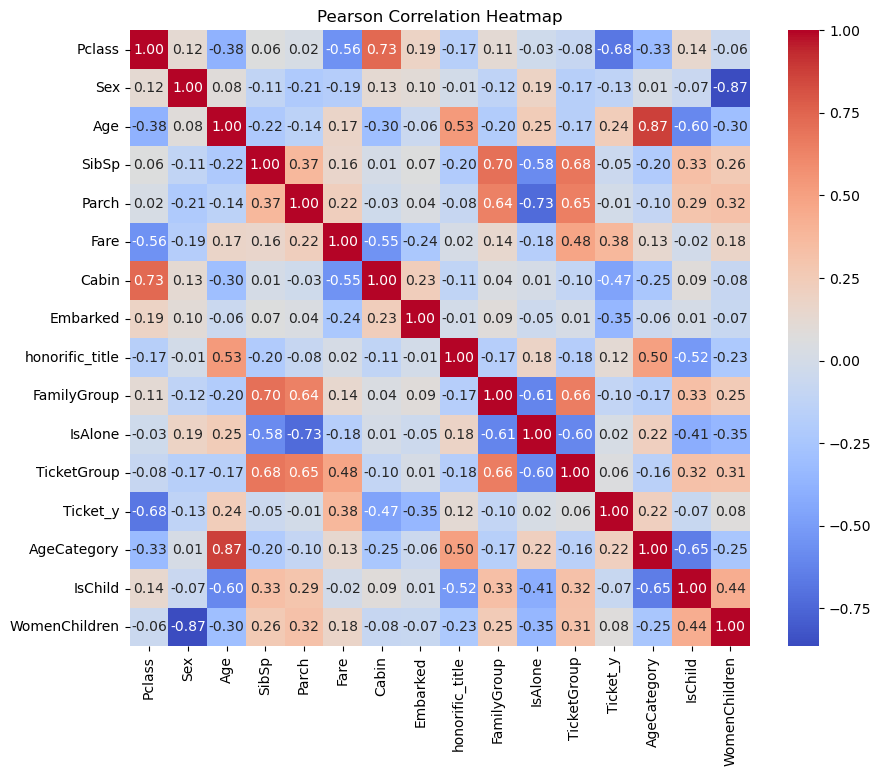

In [36]:
# 피어슨 계수 행렬 시각화
corr_matrix = pd.get_dummies(df).corr(method='pearson')

plt.figure(figsize=(10, 8))
sns.heatmap(
    corr_matrix, annot=True, cmap='coolwarm', fmt=".2f"
)
plt.title("Pearson Correlation Heatmap")
plt.show()

### 데이터프레임 확인

In [37]:
df.head()

Pclass  Sex     Age  SibSp  Parch      Fare  Cabin  Embarked  \
0       3    1  0.2750      1      0  0.014151      8         2   
1       1    0  0.4750      1      0  0.139136      2         0   
2       3    0  0.3250      0      0  0.015469      8         2   
3       1    0  0.4375      1      0  0.103644      2         2   
4       3    1  0.4375      0      0  0.015713      8         2   

   honorific_title  FamilyGroup  IsAlone  TicketGroup  Ticket_y  AgeCategory  \
0                2            2        1            1         1            2   
1                3            2        1            2        16            3   
2                1            1        1            1        11            2   
3                3            2        1            2        15            2   
4                2            2        1            1         5            2   

   IsChild  WomenChildren  
0        0              0  
1        0              1  
2        0              1  
3        0              1  
4        0              0

# LightGBM Training 🏋️‍♂️

## 학습데이터의 데이터와 답 분리

In [38]:
train_set = df.iloc[:891,]
test_set = df.iloc[891:,]

In [39]:
# 학습데이터의 데이터와 답 분리
X_train = train_set
y_train = df_train['Survived']

# 테스트데이터 생성
X_test = test_set

## 학습데이터로 검증데이터 추출

In [40]:
# 학습데이터로 검증데이터 추출
X_tr, X_val, y_tr, y_val = train_test_split(
      X_train
    , y_train
    , test_size=0.1
    , random_state=42
)

# 학습데이터와 검증데이터 세팅
evals = [(X_tr, y_tr), (X_val, y_val)]

## 하이퍼파라미터 튜닝

In [41]:
# 1 step : search space 설정, XGBosst 하이퍼파라미터들의 범위 지정
lgbm_search_space = {
      'num_leaves' : hp.quniform('num_leaves', 32, 64, 1)
    , 'max_depth' : hp.quniform('max_depth', 100, 169, 1) # return float
    , 'min_child_weight' : hp.quniform('min_child_weight', 60, 100, 1)
    , 'learning_rate' : hp.uniform('learning_rate', 0.01, 0.2)
    , 'subsample' : hp.uniform('subsample', 0.5, 1)
}

In [42]:
# 2 step : objective function => return acccuracy, auc
def objective_func(search_space):
    lgbm_clf = LGBMClassifier(
          n_estimators=100
        , num_leaves=int(search_space['num_leaves'])
        , max_depth=int(search_space['max_depth'])
        , min_child_weight=int(search_space['min_child_weight'])
        , learning_rate=search_space['learning_rate']
        , subsample=search_space['subsample']
        # , eval_metric='logloss'
    )
    accuracy = cross_val_score( # returns [정확도, 정확도, ..., 정확도]
          lgbm_clf # 교차검증할 알고리즘 적용, 사이킷런 기반 알고리즘들은 다 들어갈 수 있다.
        , X_train # 전체 학습데이터
        , y_train # 전체 학습데이터의 답
        , scoring='accuracy'
        , cv=5
    ) # -1(-100), -0.8(-80)
    return {'loss':-1*np.mean(accuracy), 'status':STATUS_OK}

In [43]:
# 3 STEP : fmin => best
trial_val = Trials() # 결과 저장하는 객체
best = fmin(
      fn=objective_func
    , space=lgbm_search_space
    , algo=tpe.suggest
    , max_evals=50
    , trials=trial_val # 중간 결과 저장
    , rstate=np.random.default_rng(seed=42)
)

100%|██████████| 50/50 [00:07<00:00,  6.49trial/s, best loss: -0.7923859142552258]


In [44]:
print(f'best : {best}')
print(best['learning_rate'])

best : {'learning_rate': 0.14573539889241496, 'max_depth': 148.0, 'min_child_weight': 63.0, 'num_leaves': 40.0, 'subsample': 0.9543339023563873}
0.14573539889241496


In [45]:
# 4 STEP : BEST MODEL
lgbm_clf = LGBMClassifier(
    n_estimators=100,
    num_leaves=int(best['num_leaves']),
    learning_rate=round(best['learning_rate'], 5),
    max_depth=int(best['max_depth']),
    min_child_weight=int(best['min_child_weight']),
    subsample=round(best['subsample'], 5)
)

# Submission File 🏆🎯

In [46]:
# 생성한 모델로 학습
# 학습
lgbm_clf.fit(
     X_tr, y_tr
    # , early_stopping_rounds=50
    , callbacks=[lightgbm.early_stopping(stopping_rounds=100)]
    , eval_metric='logloss'
    , eval_set=evals
)

Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[47]	training's binary_logloss: 0.449447	valid_1's binary_logloss: 0.42406


LGBMClassifier(learning_rate=0.14574, max_depth=148, min_child_weight=63,
               num_leaves=40, subsample=0.95433)

In [47]:
# 테스트데이터 넣어서 예측
pred = lgbm_clf.predict(X_test)

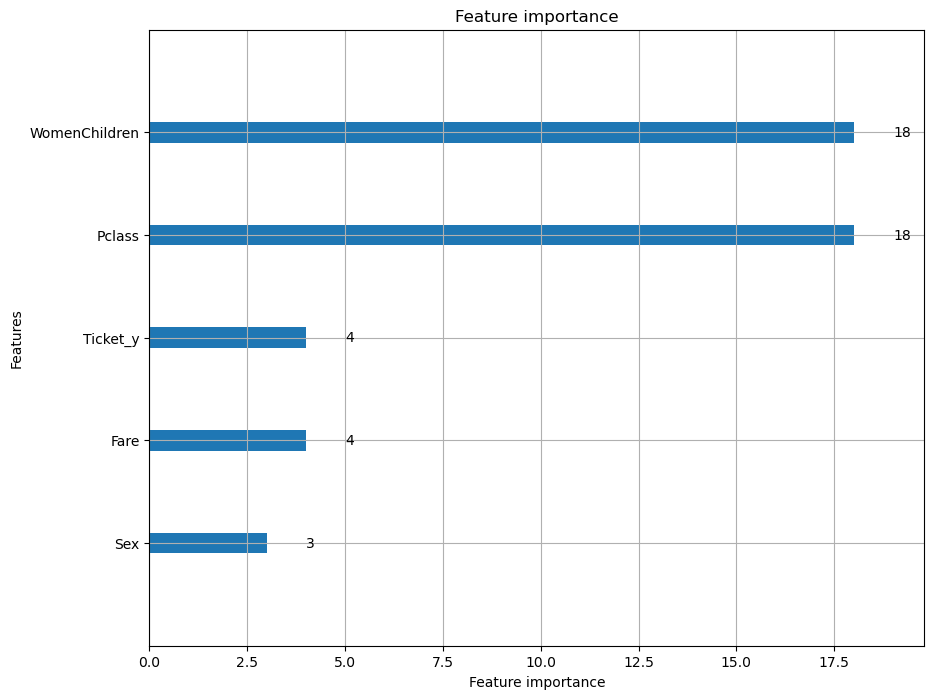

In [48]:
# 피처 중요도 시각화
from lightgbm import plot_importance
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(figsize=(10,8))
plot_importance(lgbm_clf, ax=ax)
plt.show()

In [49]:
# 제출파일 준비: PassengerId - Survived
submission = pd.DataFrame({
    'PassengerId' : df_test['PassengerId'],
    'Survived' : pred
})

submission['Survived'] = submission['Survived'].astype(int)

In [50]:
# 제출파일 저장
submission.to_csv('submission.csv', index=False)
print('your submission file is saved!')

your submission file is saved!


## 채점하기

In [51]:
# 생성된 데이터 파일과 솔루션 불러오기
# 파일 경로 적절히 수정해서 쓰세요.
submission = pd.read_csv('./submission.csv')
solution = pd.read_csv('./solution.csv')

In [52]:
# 채점 테이블 생성
marking = submission.merge(solution, on='PassengerId')
marking.columns = ['PassengerId', 'Submission', 'Solution']

# 'Check' : 맞으면 1, 틀리면 0
marking['Check'] = 0

In [53]:
# 채점
cond = marking['Submission'] == marking['Solution']
marking.loc[cond, 'Check'] = 1

# 정답 계산 및 출력
result = marking['Check'].sum() / marking.shape[0]
print('정답: {0:.5f}'.format(result))

정답: 0.76794
